# ハイパーパラメータとモデルの妥当性の確認

## モデルの妥当性に関する検討
### 誤った方法のモデルの妥当性の確認
データの読み込み

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

モデルとハイパーパラメータの選択。ここではK近傍法を利用して、ハイパーパラメータは1。

In [2]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

モデルを学習し、既知のデータに対するラベルの予測に使用する。

In [3]:
model.fit(X, y)
y_model = model.predict(X)

モデルの精度を計算する。

In [4]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

精度100%となっている。しかし、モデルの作成と、モデルの評価で同じデータを使っているという欠陥がある。加えて、nearest neighbor modelは新しいデータと、トレーニングデータとを単純に比較するもので、ハイパーパラメータが1であれば、何度やっても100%の精度となる。

### 正しい方法のモデルの妥当性の確認
モデルの学習データから、いくつかのサブセットをとっておいて、モデルの評価に使用する。この分割は`train_test_split`を使用して行うことが出来る。

In [5]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  test_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

約90%という、よりまともな結果が得られた。取っておいたデータセットは未知のデータに等しい。なぜなら、そのモデルはそれまどそれを見たことがないからだ。

### クロスバリデーションによるモデルの妥当性の確認
先ほどのようにデータを取っておく方法（holdout set)はモデルの学習に使用するデータの一部を失うことになる。上の例では、半分のデータセットがモデルの学習に貢献することがない。これは最適でないし、問題を起こす。特に、始めの学習データが少ない時には。

これを解決する方法一つとしてクロスバリデーションが利用される。それはそれぞれのサブセットを学習セットにも妥当性確認のセットにも使用するフィットを何度か行う。

ここでは、2つのバリデーションを試みて、代わりにそれぞれ半分のデータをテストに使用する。前に分割したデータを使用して、以下の様にそれを行うことが出来る。

In [6]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

この2つのスコアの平均を取れば、大局的なモデルの性能のよりより測定を得ることが出来る。ここでは2つに分けてクロスバリデーションを行った。

この考えを拡張して、より多くの試みやデータの折りたたみを利用することができる。ここでは5回の折り畳みでやってみる。

ここではデータを5つのグループに分割し、それらをそれぞれモデルの評価に利用する。モデルは残りの4/5のデータでフィットを行う。これを手でやるのは少しうんざりする。Scikit-Learnは`cross_val_score`という便利なルーチンで効率的にそれを行うことが出来る。

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

異なるデータのサブセットに渡ってバリデーションを繰り返すことはよりよいアルゴリズムのパフォーマンスのアイデアを与える。

Scikit-Learnは特定の状況で便利ないくつかのクロスバリデーションのスキームを実装s停る。これらは`cross_validation`モジュールでイテレータで定義される。例えば、極端なデータ点の数と折り畳みの数が同じという極端なケースを試したいような場合である。それはそれぞれの試験で使用する1点を除いて全ての点を学習する。このタイプのバリデーションはlearve-one-out cross validationとして知られ、次の通りに使用することが出来る。

In [8]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

150点を持っているので、当然150回のスコアある。そしてスコアは成功(1.0)か失敗(0.0)かを示唆する。それらの平均をとればエラーレートの予測が得られる。

In [9]:
scores.mean()

0.96

## 最適なモデルの選択
もし選択したモデルのパフォーマンスが芳しくないなら、どのようにして前に進めるのか。いくつかの答えがある。

- より複雑で柔軟なモデルを利用する
- より単純で柔軟性のないモデルを利用する
- より多くの訓練サンプルを集める
- それぞれのサンプルの特徴を増やすためのデータをより集める

### Bias-Variance Tradeoff
基本的に「最適なモデル」という問題はバイアスと分散のトレードオフにおいてスウィートスポットを探すことである。（ここでいうバイアスは真値に対する誤差、分散とは関数の形の変化を指すと考える。単純なモデルの場合は関数の形は大きく変わらない（低分散：Low Variance）が、誤差が大きい（高バイアス）。複雑なモデルは関数の形が大きく変わる（高分散）が誤差は小さくなる。[参考](http://blog.neko-ni-naritai.com/entry/2017/12/03/003002)）

例えば、二次関数に沿って分布するサンプルを回帰分析する状況を考える。

これを一次の回帰でフィットした場合、このモデルではこのデータセットを説明できることはない。このような場合はデータのアンダーフィットと呼ばれ、それは全てのデータを適切に説明出来るだけの十分なモデルの柔軟さがない。言い換えるならば、このモデルは高バイアスである。

一方、2次を多く聞こえる次数の回帰でフィットした場合、データの精密な特徴をほぼ完全に説明できるだけの十分な柔軟性を持ち、トレーニングデータを正確に説明するけれども、その正確な形は、そのデータを生成したプロセスの本質的な特性ではなく、あるノイズの特性をより反映しているようである。このようなモデルはオーバーフィットと呼ばれる。モデルの高い柔軟性により、モデルは結局実際のデータの分布と共にランダムなエラーをも考慮に入れている。言い換えれば、そのモデルは高い分散を備える。

一般的にモデルの複雑性が高くなるほど、トレーニングスコアも高くなる。一方、バリデーションスコアはあるところを境に下降する。最もよいモデルは、バリデーションスコアの頂点の所となる。

### Scikit-Learnでのバリデーション曲線
ここでは多項回帰モデルを使用して、モデルに対するバリデーション曲線を計算する。

例えば1次の式では直線のデートに対してフィットし、そのモデルのパラメータは$a$と$b$となる。

$$ y = ax + b$$

3次の多項式はデータに対して3次曲線でフィットし、そのモデルパラメータは$a,b,c,d$である。

$$ y = ax^3 + bx^2 + cx +b $$

Scikit-Learnではこれをシンプルな線形回帰と多項式プリプロセッサを組み合わせることで実装できる。

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

モデルでフィットするデータを生成する。

以下ではXが0から1の範囲でランダムな点をとり、yは次のような式でサンプルしている。エラーは正規分布としている。

$$ y = 10 - 1 / ( x + 0.1 ) + err  $$

In [11]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

ここで、いくつかの次元でのフィットを取りデータの可視化を行う。

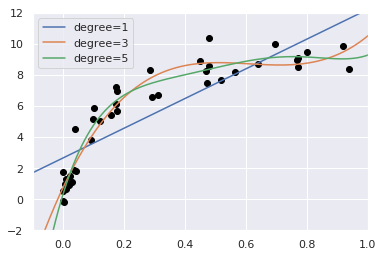

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

バリデーション曲線を描画して、どのモデルが最適かを検討する。これはScikit-Learnが提供する便利なルーチンである`validation_curve`を使用すれば簡単に行える。モデルとでデータ、パラメータ名、探索の範囲を与えれば、この関数は自動的にその範囲にわたって、トレーニングスコアとバリデーションスコアを計算する。

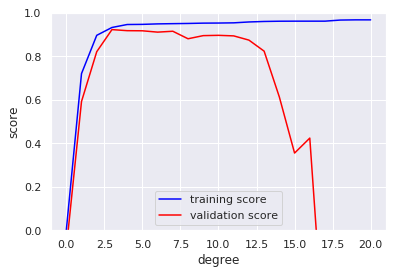

In [13]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

この図からも、トレーニングスコアはどこでもバリデーションスコアより高いことが分かる。また、トレーニングスコアはモデルの複雑性が増すほど改善されるが、バリデーションスコアはモデルのオーバーフィットによって下降する前で最大に達することも分かる。

バリデーションスコアから3次でのフィットが一番よさそうであるため、これをプロットする。

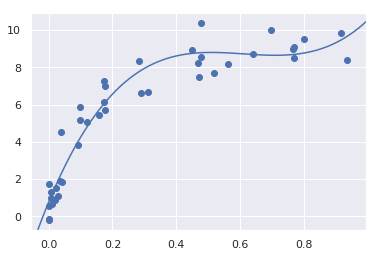

In [14]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

## 学習曲線
トレーニングデータの量に応じた、モデルのフィットを検討する。始めに学習店を5倍に増やした新しいデータセットを生成する。

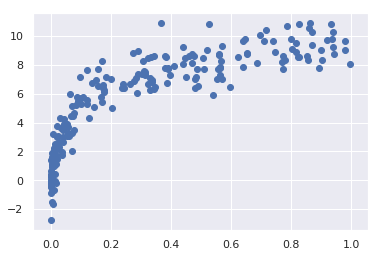

In [15]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

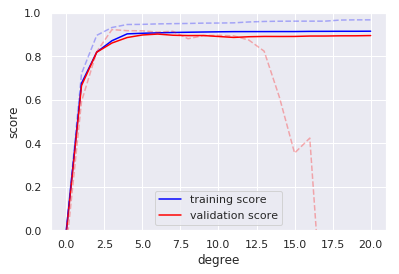

In [16]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

実線が新しい結果で、破線が前回の少ないデータ量での結果である。これを見ると次元が多いデータセットでも上手く表現できているようにも見える。ここでのピークはおそらく6次くらいのようであるが、20次のモデルでも極端にオーバーフィッチングという訳でなく、トレーニングスコアとバリデーションスコアがほぼ同じくらいとなっている。

すなわち、バリエーション曲線は1つの入力でなく、2つの重要な入力で形状が変わることが分かる。それは、モデルの複雑性と、トレーニング点の数である。

トレーニング点とトレーニングスコア、バリデーションスコアのプロットは学習曲線として知られる。

期待される一般的な学習曲線の振る舞いは次の通りである。

- 小さいデータセットに対して複雑なモデルがオーバーフィットする。つまり、トレーニングスコアは比較的高いが、バリデーションスコアは比較的低い
- 大きいデータセットに対して複雑なモデルがアンダーフィットする。つまり、トレーニングスコアは下がるが、バリデーションスコアは上がる
- モデルのトレーニングスコアがバリデーションスコアを超えることがない。曲線は近接することはあっても、交わることはない。

モデルが収束するのに十分な点を持ったならばトレーニングデータを増やすことが役立つことはない。この場合でのモデルの性能を上げる唯一の方法は、異なるモデル（しばしばより複雑なモデル）を利用することである。

### Scikit-Learnでの学習曲線
Scikit-Learnではモデルの学習曲線を計算する便利な機能がある。ここでは、2次と9次のモデルで元のデータセットに対する学習曲線を計算する。

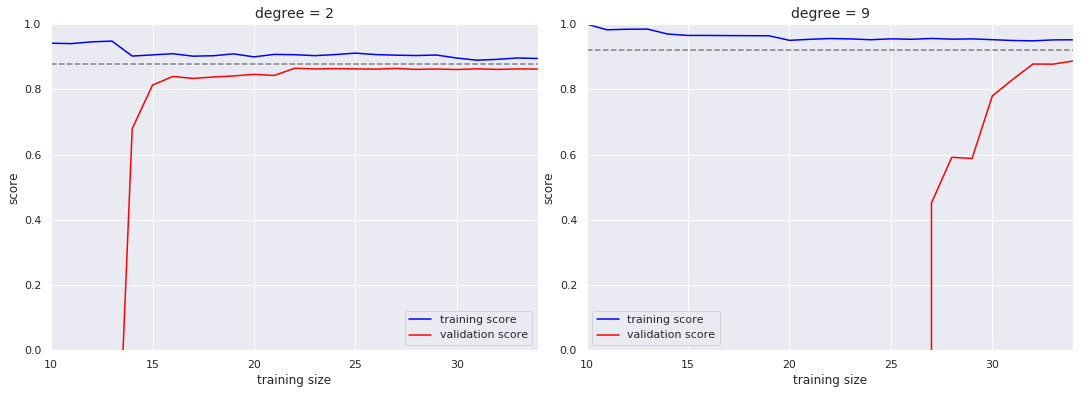

In [17]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

## 実際のバリデーション：Grid Search
これまで見てきたモデルは次元数のみをパラメータとするものであった。実際には、一つ以上のパラメータをもつモデルが一般的であり、バリデーション曲線や学習曲線も線から多次元の平面となる。このような場合、可視化を行うのが難しくなり、バリエーションスコアを最大化するモデルを単に探すことが出来なくなる。

Scikit-Learnはgrid searchモジュールによってこれを行う自動化ツールを提供する。ここでは最適な多項モデルを探すのにgrid searchを使用する例を示す。モデルの特徴量の3次元グリッドを探索する。つまり、多項式次数、切片をフィットするかのフラグ、問題の正規化を行うかどうかのフラグ。これはScikit-Learnの`GridSearchCV`を使用してセットアップできる。

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

In [19]:
grid.fit(X, y);

/home/sasaki/.pyenv/versions/miniconda3-4.3.30/envs/ml_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [20]:
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

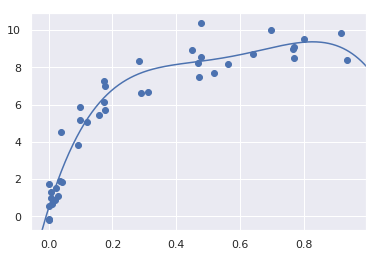

In [21]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

grid searchはより多くのオプションを用意しており、カスタムのスコア関数の指定や、計算の並列化、ランダムサーチなどがある。